# Machine Learning Approach

In [1]:
# Local libraries
import Tools.ratings_utils as ru
import Tools.system_utils as sys
import Tools.season_utils as su

# Third party packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

YEARS = [2022]
# YEARS = [2021, 2022, 2023, 2024, 2025]
WRITE_TO_CSV = False


_, tournament_filename, picks_filename, ratings_filename, final_ratings_filename = su.create_filenames(years=YEARS)

# Create data frame for valid teams in the current season that can be used for tournament simulation
score_df = ru.create_score_df(years=YEARS)
rating_score_df = None

/Users/derekfromtexas/anaconda3/envs/college-hoops/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read data from JSON
rating_score_df = pd.read_json(ratings_filename)

# Set data frame and target variable
df = rating_score_df.copy()
df["y"] = (df["Winner"] == df["Home"]).astype(int)

# Add feature columns
# TODO Move this to mid-season ratings_per_game function
df = ru.derive_features(df=df, final_ratings_filename=final_ratings_filename)

# Set features
features = ru.ML_FEATURES

# Create X, y data frames
X = df[features]
y = df["y"]

# Split train/test data sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up final ratings for tournament
ratings_dict = ru.compile_ratings_dict(final_ratings_filename=final_ratings_filename)

# Logistic Regression Model - Option #1
### Home team is winner -> 1
### Away team is winner -> 0

In [3]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [4]:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

In [5]:
# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print neatly
print(f"Logistic Regression Model\nPerformance Metrics:")
print(f"---------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Model
Performance Metrics:
---------------------------
Accuracy : 0.7636
Precision: 0.7935
Recall   : 0.9095
F1 Score : 0.8476
ROC AUC  : 0.7651

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47       331
           1       0.79      0.91      0.85       862

    accuracy                           0.76      1193
   macro avg       0.71      0.65      0.66      1193
weighted avg       0.75      0.76      0.74      1193



In [6]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_model.coef_[0]
})
print(coef_df)

                Feature  Coefficient
0           Massey_diff     0.129451
1           Colley_diff     1.552796
2              Elo_diff    -0.003998
3          Adj_Elo_diff     0.001461
4      Avg_Pts_For_diff    -0.006772
5  Avg_Pts_Against_diff    -0.001208
6      Avg_Net_Pts_diff    -0.005564


# Test Logistic Regression Model Against March Madness Tournament

In [7]:
_, _, tourney_dict, results = ru.simulate_tournament_with_all_ratings(
    filename=tournament_filename,
    ratings=ratings_dict,
    model=log_model)

print(results)

if WRITE_TO_CSV:
    sys.write_tournament_to_csv(tourney_dict=tourney_dict,
                                filename=picks_filename,
                                rating_type="log_model")

Round: 1 / Round of 64 - Correct picks: 22 out of 32 - Total Points: 220 out of 320
Round: 2 / Round of 32 - Correct picks: 10 out of 16 - Total Points: 200 out of 320
Round: 3 / Sweet 16 - Correct picks: 2 out of 8 - Total Points: 80 out of 320
Round: 4 / Elite 8 - Correct picks: 1 out of 4 - Total Points: 80 out of 320
Round: 5 / Final 4 - Correct picks: 1 out of 2 - Total Points: 160 out of 320
Round: 6 / Championship - Correct picks: 1 out of 1 - Total Points: 320 out of 320

Total correct picks in tournament: 37 out of 63
Total points in tournament: 1060 out of 1920


# XGBoost Model - Option #2

In [8]:
# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

/Users/derekfromtexas/anaconda3/envs/college-hoops/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:37:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
# Evaluate
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

In [10]:
# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print neatly
print(f"XGBoost Model\nPerformance Metrics:")
print(f"---------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

XGBoost Model
Performance Metrics:
---------------------------
Accuracy : 0.7502
Precision: 0.7975
Recall   : 0.8770
F1 Score : 0.8354
ROC AUC  : 0.7657

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.42      0.48       331
           1       0.80      0.88      0.84       862

    accuracy                           0.75      1193
   macro avg       0.68      0.65      0.66      1193
weighted avg       0.73      0.75      0.74      1193



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

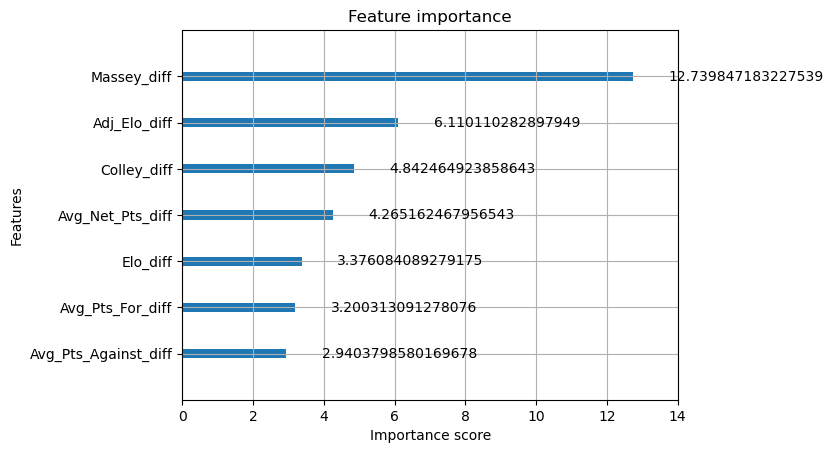

In [11]:
xgb.plot_importance(xgb_model, importance_type="gain")

# Test XGBoost Model Against March Madness Tournament

In [12]:
_, _, tourney_dict, results = ru.simulate_tournament_with_all_ratings(
    filename=tournament_filename,
    ratings=ratings_dict,
    model=xgb_model)

print(results)

if WRITE_TO_CSV:
    sys.write_tournament_to_csv(tourney_dict=tourney_dict,
                                filename=picks_filename,
                                rating_type="xgb_model")

Round: 1 / Round of 64 - Correct picks: 22 out of 32 - Total Points: 220 out of 320
Round: 2 / Round of 32 - Correct picks: 10 out of 16 - Total Points: 200 out of 320
Round: 3 / Sweet 16 - Correct picks: 3 out of 8 - Total Points: 120 out of 320
Round: 4 / Elite 8 - Correct picks: 1 out of 4 - Total Points: 80 out of 320
Round: 5 / Final 4 - Correct picks: 1 out of 2 - Total Points: 160 out of 320
Round: 6 / Championship - Correct picks: 1 out of 1 - Total Points: 320 out of 320

Total correct picks in tournament: 38 out of 63
Total points in tournament: 1100 out of 1920


# Random Forest - Option #3

In [13]:
# Define Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=500,      # number of trees
    max_depth=None,       # let trees go deep until pure
    min_samples_split=2,  # default
    min_samples_leaf=1,   # default
    max_features="sqrt",  # good for classification
    random_state=42,
    n_jobs=-1             # use all cores
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [14]:
# Evaluate
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

In [15]:
# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print neatly
print(f"Random Forest Model\nPerformance Metrics:")
print(f"---------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Model
Performance Metrics:
---------------------------
Accuracy : 0.7502
Precision: 0.8000
Recall   : 0.8724
F1 Score : 0.8346
ROC AUC  : 0.7657

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       331
           1       0.80      0.87      0.83       862

    accuracy                           0.75      1193
   macro avg       0.68      0.65      0.66      1193
weighted avg       0.73      0.75      0.74      1193



In [16]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))

Massey_diff             0.202994
Adj_Elo_diff            0.151910
Colley_diff             0.148857
Elo_diff                0.142016
Avg_Net_Pts_diff        0.134497
Avg_Pts_For_diff        0.111816
Avg_Pts_Against_diff    0.107911
dtype: float64


In [17]:
_, _, tourney_dict, results = ru.simulate_tournament_with_all_ratings(
    filename=tournament_filename,
    ratings=ratings_dict,
    model=rf_model)

print(results)

if WRITE_TO_CSV:
    sys.write_tournament_to_csv(tourney_dict=tourney_dict,
                                filename=picks_filename,
                                rating_type="rf_model")

Round: 1 / Round of 64 - Correct picks: 22 out of 32 - Total Points: 220 out of 320
Round: 2 / Round of 32 - Correct picks: 10 out of 16 - Total Points: 200 out of 320
Round: 3 / Sweet 16 - Correct picks: 3 out of 8 - Total Points: 120 out of 320
Round: 4 / Elite 8 - Correct picks: 1 out of 4 - Total Points: 80 out of 320
Round: 5 / Final 4 - Correct picks: 0 out of 2 - Total Points: 0 out of 320
Round: 6 / Championship - Correct picks: 0 out of 1 - Total Points: 0 out of 320

Total correct picks in tournament: 36 out of 63
Total points in tournament: 620 out of 1920


## Exploratory Data Anaysis per feature (Plotting)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_feature_vs_win(df, feature_col, target_col='y'):
    y = df[target_col].values
    x = df[feature_col].values

    # jitter Y so points don't stack
    y_jitter = y + np.random.normal(0, 0.03, size=len(y))

    plt.figure(figsize=(6,4))
    plt.scatter(x, y_jitter, alpha=0.4)
    plt.yticks([0, 1], ['Loss', 'Win'])
    plt.xlabel(feature_col)
    plt.ylabel('Outcome')
    plt.title(f'Win vs {feature_col}')
    plt.grid(alpha=0.3)
    plt.show()


def plot_binned_win_rate(df, feature_col, target_col='y', bins=10):
    x = df[feature_col]
    y = df[target_col]

    df_tmp = df.copy()
    df_tmp['bin'] = pd.qcut(x, bins, duplicates='drop')

    win_rate = df_tmp.groupby('bin')[target_col].mean()
    bin_mid = [interval.mid for interval in win_rate.index]

    plt.figure(figsize=(6,4))
    plt.plot(bin_mid, win_rate, marker='o')
    plt.xlabel(feature_col)
    plt.ylabel('Win Probability')
    plt.title(f'Binned Win Rate vs {feature_col}')
    plt.grid(alpha=0.3)
    plt.show()


def plot_binned_win_rate_fixed(df, feature_col, target_col='y', bins=10):
    x = df[feature_col]
    y = df[target_col]

    df_tmp = df.copy()
    df_tmp['bin'] = pd.cut(x, bins=bins)

    win_rate = df_tmp.groupby('bin')[target_col].mean()
    bin_mid = [interval.mid for interval in win_rate.index]

    plt.figure(figsize=(6,4))
    plt.plot(bin_mid, win_rate, marker='o')
    plt.xlabel(feature_col)
    plt.ylabel('Home Win Probability')
    plt.title(f'Binned Win Rate vs {feature_col}')
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
# Run plots for target outcome (home team wins) against all features
for feature in ru.ML_FEATURES:
    # plot_feature_vs_win(df, feature)
    # plot_binned_win_rate(df, feature)
    plot_binned_win_rate_fixed(df, feature)

## Save Ratings to JSON
### (Skip if already run for this season)

In [ ]:
rating_score_df, final_ratings_df = ru.add_ratings_per_game(
    score_df=score_df,
    ratings_filename=ratings_filename,
    final_ratings_filename=final_ratings_filename
)